In [1]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import brier_score_loss, make_scorer
from sklearn.model_selection import GridSearchCV
import numpy as np

import matplotlib.pyplot as plt

In [2]:
X, y = make_classification(
    n_samples=1000,
    weights=[0.99],
    random_state=100
)
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)

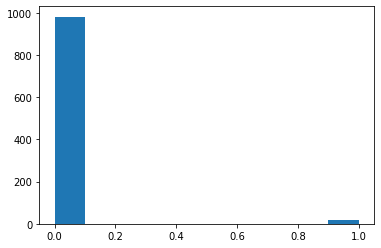

In [3]:
plt.hist(y)
plt.show()

brier score for the 0-skill model

In [4]:
prob_arr = [0.01 for _ in range(y_test.shape[0])]
brier_ref = brier_score_loss(y_test, prob_arr)
print("Brier score for 0-skill classifier model, for P(class1=0) is {}".format(round(brier_ref, 5)))

prob_arr = [1.0 for _ in range(y_test.shape[0])]
brier_ref = brier_score_loss(y_test, prob_arr)
print("Brier score for 0-skill classifier model, for P(class1=1) is {}".format(round(brier_ref, 5)))

Brier score for 0-skill classifier model, for P(class1=0) is 0.0197
Brier score for 0-skill classifier model, for P(class1=1) is 0.98


define the brier skill score

In [5]:
def bss(y_test, prob_arr):
    ref_prob_arr = [0.01 for _ in range(y_test.shape[0])]
    brier_ref = brier_score_loss(y_test, ref_prob_arr)
    brier_score = brier_score_loss(y_test, prob_arr)
    return round(1-(brier_score/brier_ref), 5)

bss_scorer = make_scorer(bss, needs_proba=True)

lets see the perfect bss

In [6]:
print("Perfect BSS is {}".format(bss(y_test, y_test)))

Perfect BSS is 1.0


In [7]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

Testing Brier score for SVC

In [8]:
svc = SVC(probability=True)
svc.fit(X_train, y_train)
pred_prob = svc.predict_proba(X_test)
print(svc.classes_)
print("Brier skill score for SVM classifier model is {}".format(bss(y_test, pred_prob[:, 1])))

[0 1]
Brier skill score for SVM classifier model is 0.15818


In [11]:
print(y_test[:5], pred_prob[:5, 1])

[0 0 0 0 0] [0.0038701  0.02729082 0.01695708 0.02032525 0.02347346]


In [14]:
print(y_test[y_test == 1], "\n", pred_prob[y_test == 1])

[1 1 1 1] 
 [[0.9766328  0.0233672 ]
 [0.99605361 0.00394639]
 [0.33689147 0.66310853]
 [0.99424135 0.00575865]]


Testing BSS for kNN

In [27]:
knc = KNeighborsClassifier()

knc_param_dict = {
    "n_neighbors":[i for i in range(1, 11)],
    "weights": ['uniform', 'distance'],
    "algorithm": ['auto', 'ball_tree', 'kd_tree', 'brute'],
    "leaf_size": [i for i in range(10, 100, 10)],
    "p": [i for i in range(1, 11)]
}
cv_model = GridSearchCV(estimator=knc, param_grid=knc_param_dict, scoring=bss_scorer, n_jobs=2)
cv_model.fit(X_train, y_train)
best_knc = cv_model.best_estimator_
best_knc.fit(X_train, y_train)
pred_prob = best_knc.predict_proba(X_test)
print(best_knc.classes_)

# print("Brier skill score for KNN classifier model is {}".format(bss(y_test, pred_prob[:, 1])))

[0 1]


In [29]:
print("Best model params are \n{}\n\n".format(cv_model.best_params_))
print("Brier skill score for KNN classifier model is {}".format(cv_model.best_score_))

Best model params are 
{'algorithm': 'auto', 'leaf_size': 10, 'n_neighbors': 9, 'p': 1, 'weights': 'distance'}


Brier skill score for KNN classifier model is 0.11552799999999999


In [30]:
import pandas as pd
from IPython.display import display

df = pd.DataFrame(cv_model.cv_results_)
display(df)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_algorithm,param_leaf_size,param_n_neighbors,param_p,param_weights,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.001690,0.000190,0.007181,0.000638,auto,10,1,1,uniform,"{'algorithm': 'auto', 'leaf_size': 10, 'n_neig...",-0.51822,-1.70636,-0.01488,-0.01488,-0.01488,-0.453844,0.655898,7129
1,0.002047,0.000551,0.007845,0.000507,auto,10,1,1,distance,"{'algorithm': 'auto', 'leaf_size': 10, 'n_neig...",-0.51822,-1.70636,-0.01488,-0.01488,-0.01488,-0.453844,0.655898,7129
2,0.001737,0.000255,0.008361,0.001223,auto,10,1,2,uniform,"{'algorithm': 'auto', 'leaf_size': 10, 'n_neig...",-0.01215,-1.02977,-0.35318,0.32341,-0.01488,-0.217314,0.459129,6625
3,0.001495,0.000092,0.007949,0.000622,auto,10,1,2,distance,"{'algorithm': 'auto', 'leaf_size': 10, 'n_neig...",-0.01215,-1.02977,-0.35318,0.32341,-0.01488,-0.217314,0.459129,6625
4,0.001552,0.000113,0.128131,0.002738,auto,10,1,3,uniform,"{'algorithm': 'auto', 'leaf_size': 10, 'n_neig...",-0.01215,-1.02977,-0.69147,0.66171,-0.01488,-0.217312,0.590028,6553
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7195,0.000452,0.000010,0.155414,0.003145,brute,90,10,8,distance,"{'algorithm': 'brute', 'leaf_size': 90, 'n_nei...",-0.16598,-0.09985,-0.12422,0.32079,0.08628,0.003404,0.180689,3421
7196,0.000465,0.000037,0.154800,0.003063,brute,90,10,9,uniform,"{'algorithm': 'brute', 'leaf_size': 90, 'n_nei...",-0.17915,-0.10284,-0.10622,0.29296,0.06969,-0.005112,0.170003,3673
7197,0.000494,0.000116,0.156747,0.002213,brute,90,10,9,distance,"{'algorithm': 'brute', 'leaf_size': 90, 'n_nei...",-0.17451,-0.09345,-0.11170,0.32231,0.07929,0.004388,0.179854,3277
7198,0.000511,0.000127,0.170259,0.020905,brute,90,10,10,uniform,"{'algorithm': 'brute', 'leaf_size': 90, 'n_nei...",-0.15891,-0.09946,-0.10622,0.28958,0.07645,0.000288,0.165002,3529


# Imbalanced Datasets

The [credit card fraud detection](https://www.kaggle.com/mlg-ulb/creditcardfraud) dataset will be used \
The **Class** column in the dataset indicates whether the card is fraud or not.


In [1]:
!pip install imbalanced-learn

You should consider upgrading via the '/home/laferrari/anaconda3/envs/tensorflow_cpu/bin/python -m pip install --upgrade pip' command.


In [2]:
import os
zipPath = ""
for fileName in os.listdir("./"):
    if fileName.endswith(".zip"):
        zipPath = os.path.relpath(fileName)
!unzip {zipPath}

Archive:  credit-card-fraud-dataset.zip
  inflating: creditcard.csv          


In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from IPython.display import display

df = pd.read_csv("./creditcard.csv")
display(df.head())

print(df.dtypes)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


Time      float64
V1        float64
V2        float64
V3        float64
V4        float64
V5        float64
V6        float64
V7        float64
V8        float64
V9        float64
V10       float64
V11       float64
V12       float64
V13       float64
V14       float64
V15       float64
V16       float64
V17       float64
V18       float64
V19       float64
V20       float64
V21       float64
V22       float64
V23       float64
V24       float64
V25       float64
V26       float64
V27       float64
V28       float64
Amount    float64
Class       int64
dtype: object


firstly, it is clear that no categorical encoding is needed since all variables are either continuous or discrete

In [5]:
print(df.shape)

(284807, 31)


In [7]:
print(df.isnull().sum())

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64


Good, so no null values are present in this dataset

In [10]:
df['Class'].value_counts()

0    284315
1       492
Name: Class, dtype: int64

Hence positive classes are so many, and negative classes are so less compared to them.

In [18]:
x, y = df.drop("Class", axis=1), df['Class']

from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.7)

In [19]:
import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import KFold, GridSearchCV

lc = LogisticRegression()
grid = {
    'C': 10.0**np.arange(-2, 3),
    'penalty': ['l1', 'l2'] # regularisation method
}
cv = KFold(n_splits=5, shuffle=False, random_state=42)

In [21]:
gS = GridSearchCV(
    lc,
    grid,
    n_jobs=-1,
    cv=cv,
    scoring='f1_macro'
)
gS.fit(x_train.values, y_train.values)

/home/laferrari/anaconda3/envs/tensorflow_cpu/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=False),
             estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': array([1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02]),
                         'penalty': ['l1', 'l2']},
             scoring='f1_macro')

In [22]:
clf = gS.best_estimator_
y_pred = clf.predict(x_test.values)
print("accuracy = ", accuracy_score(y_pred, y_test))

accuracy =  0.9990988144142879


In [23]:
print(confusion_matrix(y_test, y_pred))
print()
print(classification_report(y_test, y_pred))

[[85261    31]
 [   46   105]]

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85292
           1       0.77      0.70      0.73       151

    accuracy                           1.00     85443
   macro avg       0.89      0.85      0.87     85443
weighted avg       1.00      1.00      1.00     85443



Its usually believed that imbalanced dataset does not heavily impact the decision-trees and random-forest ensemble techniques

In [30]:
from sklearn.ensemble import RandomForestClassifier as RFC
rfc = RFC()
rfc.fit(x_train.values, y_train.values)

y_pred = rfc.predict(x_test.values)
pred_prob1 = rfc.predict_proba(x_test)

print("accuracy = ", accuracy_score(y_pred, y_test))
print(confusion_matrix(y_test, y_pred))
print()
print(classification_report(y_test, y_pred))

accuracy =  0.9994967405170698
[[85286     6]
 [   37   114]]

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85292
           1       0.95      0.75      0.84       151

    accuracy                           1.00     85443
   macro avg       0.97      0.88      0.92     85443
weighted avg       1.00      1.00      1.00     85443



0.8774482704215483
Threshold value for random forest classifier is:  (52,) fpr shape is (52,)


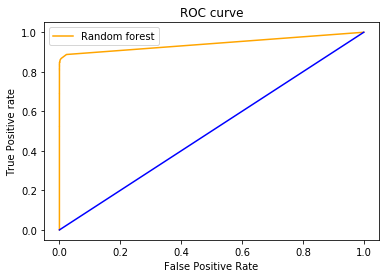

In [33]:
from sklearn.metrics import roc_auc_score, roc_curve
print(roc_auc_score(y_test, y_pred, average=None))

fpr1, tpr1, thresh1 = roc_curve(y_test, pred_prob1[:,1])

# roc curve for tpr = fpr 
random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, _ = roc_curve(y_test, random_probs, pos_label=1)

print("Threshold value for random forest classifier is: ", thresh1.shape, 
      "fpr shape is", fpr1.shape
     )

plt.plot(fpr1, tpr1, color='orange', label='Random forest')
plt.plot(p_fpr, p_tpr, color='blue')

# title
plt.title('ROC curve')
# x label
plt.xlabel('False Positive Rate')
# y label
plt.ylabel('True Positive rate')

plt.legend(loc='best')
plt.show()

# Under-sampling

* reduce the total number of samples for the class that the distribution is biased towards, i.e. the class having many more samples than some other class(es)
* should be used when the ratio is too skewed, i.e. extent of imbalance in the dataset is a lot.
* for NearMiss method of under sampling
    * $\alpha = \frac{\textrm{N}_{\textrm{m}}}{\textrm{N}_{\textrm{rM}}}$, is the value being provided as a parameter to the function call of NearMiss
    * $\textrm{N}_{\textrm{m}}$ = number of samples in the minority class after under sampling\
    $\textrm{N}_{\textrm{rM}}$ = number of samples in the Majority class after under sampling

In [38]:
from imblearn.under_sampling import NearMiss
nm = NearMiss(0.8) # reduce to 80% of original data
x_train_new, y_train_new = nm.fit_sample(x_train, y_train)
print(y_train_new.value_counts())

/home/laferrari/anaconda3/envs/tensorflow_cpu/lib/python3.6/site-packages/imblearn/utils/_validation.py:638: FutureWarning: Pass sampling_strategy=0.8 as keyword args. From version 0.9 passing these as positional arguments will result in an error
  FutureWarning)


0    426
1    341
Name: Class, dtype: int64


accuracy =  0.47511206301276876
[[40449 44843]
 [    5   146]]

              precision    recall  f1-score   support

           0       1.00      0.47      0.64     85292
           1       0.00      0.97      0.01       151

    accuracy                           0.48     85443
   macro avg       0.50      0.72      0.32     85443
weighted avg       1.00      0.48      0.64     85443

0.7205644233304647
Threshold value for random forest classifier is:  (102,) fpr shape is (102,)


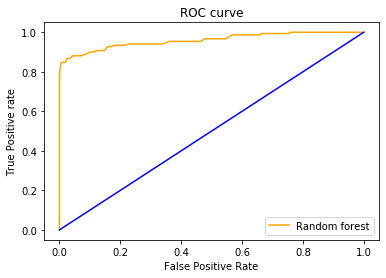

In [42]:
from sklearn.ensemble import RandomForestClassifier as RFC
rfc = RFC()
rfc.fit(x_train_new.values, y_train_new.values)

y_pred = rfc.predict(x_test.values)
pred_prob1 = rfc.predict_proba(x_test)

print("accuracy = ", accuracy_score(y_pred, y_test))
print(confusion_matrix(y_test, y_pred))
print()
print(classification_report(y_test, y_pred))

from sklearn.metrics import roc_auc_score, roc_curve
print(roc_auc_score(y_test, y_pred, average=None))

fpr1, tpr1, thresh1 = roc_curve(y_test, pred_prob1[:,1])

# roc curve for tpr = fpr 
random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, _ = roc_curve(y_test, random_probs, pos_label=1)

print("Threshold value for random forest classifier is: ", thresh1.shape, 
      "fpr shape is", fpr1.shape
     )

plt.plot(fpr1, tpr1, color='orange', label='Random forest')
plt.plot(p_fpr, p_tpr, color='blue')

# title
plt.title('ROC curve')
# x label
plt.xlabel('False Positive Rate')
# y label
plt.ylabel('True Positive rate')

plt.legend(loc='best')
plt.show()

* ROC is kind of maintained
* <font color="red">Accuracy is reduced a lot.</font>
* <font color="red">precision has slid down to 0</font>

# Over-sampling
* increase the data-points of the minority class

In [49]:
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(0.5)
x_train_new, y_train_new = ros.fit_sample(x_train, y_train)
print(y_train_new.value_counts())

/home/laferrari/anaconda3/envs/tensorflow_cpu/lib/python3.6/site-packages/imblearn/utils/_validation.py:638: FutureWarning: Pass sampling_strategy=0.5 as keyword args. From version 0.9 passing these as positional arguments will result in an error
  FutureWarning)


0    199023
1     99511
Name: Class, dtype: int64


accuracy =  0.9994733330992591
[[85288     4]
 [   41   110]]

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85292
           1       0.96      0.73      0.83       151

    accuracy                           1.00     85443
   macro avg       0.98      0.86      0.91     85443
weighted avg       1.00      1.00      1.00     85443

0.8642149617379857
Threshold value for random forest classifier is:  (61,) fpr shape is (61,)


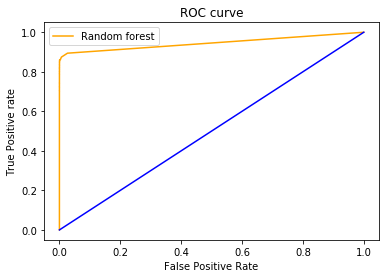

In [50]:
from sklearn.ensemble import RandomForestClassifier as RFC
rfc = RFC()
rfc.fit(x_train_new.values, y_train_new.values)

y_pred = rfc.predict(x_test.values)
pred_prob1 = rfc.predict_proba(x_test)

print("accuracy = ", accuracy_score(y_pred, y_test))
print(confusion_matrix(y_test, y_pred))
print()
print(classification_report(y_test, y_pred))

from sklearn.metrics import roc_auc_score, roc_curve
print(roc_auc_score(y_test, y_pred, average=None))

fpr1, tpr1, thresh1 = roc_curve(y_test, pred_prob1[:,1])

# roc curve for tpr = fpr 
random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, _ = roc_curve(y_test, random_probs, pos_label=1)

print("Threshold value for random forest classifier is: ", thresh1.shape, 
      "fpr shape is", fpr1.shape
     )

plt.plot(fpr1, tpr1, color='orange', label='Random forest')
plt.plot(p_fpr, p_tpr, color='blue')

# title
plt.title('ROC curve')
# x label
plt.xlabel('False Positive Rate')
# y label
plt.ylabel('True Positive rate')

plt.legend(loc='best')
plt.show()

* With about the same accuracy as that of taking the entire training data
* randomOverSampler actually reduced the total number of false-positives(type-1 error) from 6(in entire train-data) to 3(in randomly oversampled train-data), 
* and also increased the total number of true-positives from 85286(in entire train-data) to 85289(in RandomlyOverSampled train-data)
* and the AUC-ROC value has increased from 0.72 to 0.86

# SMOTETomek 

In [51]:
from imblearn.combine import SMOTETomek

sm = SMOTETomek(0.5)
x_train_new, y_train_new = sm.fit_sample(x_train, y_train)
print(y_train_new.value_counts())

/home/laferrari/anaconda3/envs/tensorflow_cpu/lib/python3.6/site-packages/imblearn/utils/_validation.py:638: FutureWarning: Pass sampling_strategy=0.5 as keyword args. From version 0.9 passing these as positional arguments will result in an error
  FutureWarning)


0    198136
1     98624
Name: Class, dtype: int64


accuracy =  0.9994616293903538
[[85274    18]
 [   28   123]]

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85292
           1       0.87      0.81      0.84       151

    accuracy                           1.00     85443
   macro avg       0.94      0.91      0.92     85443
weighted avg       1.00      1.00      1.00     85443

AUC-ROC value = 0.9071792483507378
Threshold value for random forest classifier is:  (59,) fpr shape is (59,)


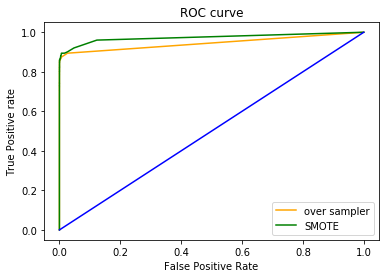

In [52]:
from sklearn.ensemble import RandomForestClassifier as RFC
rfc = RFC(n_jobs=-1)
rfc.fit(x_train_new.values, y_train_new.values)

y_pred = rfc.predict(x_test.values)
pred_prob2 = rfc.predict_proba(x_test)

print("accuracy = ", accuracy_score(y_pred, y_test))
print(confusion_matrix(y_test, y_pred))
print()
print(classification_report(y_test, y_pred))

from sklearn.metrics import roc_auc_score, roc_curve
print("AUC-ROC value =", roc_auc_score(y_test, y_pred, average=None))

fpr2, tpr2, thresh2 = roc_curve(y_test, pred_prob2[:,1])

# roc curve for tpr = fpr 
random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, _ = roc_curve(y_test, random_probs, pos_label=1)

print("Threshold value for random forest classifier is: ", thresh2.shape, 
      "fpr shape is", fpr2.shape
     )

plt.plot(fpr1, tpr1, color='orange', label='over sampler')
plt.plot(fpr2, tpr2, color='green', label='SMOTE')
plt.plot(p_fpr, p_tpr, color='blue')

# title
plt.title('ROC curve')
# x label
plt.xlabel('False Positive Rate')
# y label
plt.ylabel('True Positive rate')

plt.legend(loc='best')
plt.show()

* AUC-ROC value is greater than oversampler
* recall and f1-score are greater , but <font color="red">precision is lower</font> than oversampler
* 

# Ensemble-techniques
* don't get confused with sklearn ensembles, here we are actually using ensembles from **imblearn** module

accuracy =  0.9647952436127009
[[82296  2996]
 [   12   139]]

              precision    recall  f1-score   support

           0       1.00      0.96      0.98     85292
           1       0.04      0.92      0.08       151

    accuracy                           0.96     85443
   macro avg       0.52      0.94      0.53     85443
weighted avg       1.00      0.96      0.98     85443

AUC-ROC value = 0.9427017059898323
Threshold value for random forest classifier is:  (3831,) fpr shape is (3831,)


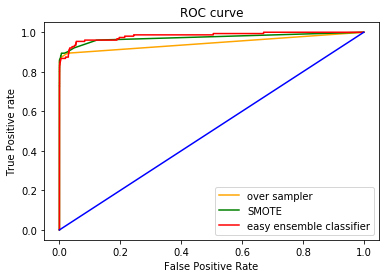

In [54]:
from imblearn.ensemble import EasyEnsembleClassifier

easy = EasyEnsembleClassifier()
easy.fit(x_train, y_train)

y_pred = easy.predict(x_test.values)
pred_prob3 = easy.predict_proba(x_test)

print("accuracy = ", accuracy_score(y_pred, y_test))
print(confusion_matrix(y_test, y_pred))
print()
print(classification_report(y_test, y_pred))

from sklearn.metrics import roc_auc_score, roc_curve
print("AUC-ROC value =", roc_auc_score(y_test, y_pred, average=None))

fpr3, tpr3, thresh3 = roc_curve(y_test, pred_prob3[:,1])

# roc curve for tpr = fpr 
random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, _ = roc_curve(y_test, random_probs, pos_label=1)

print("Threshold value for random forest classifier is: ", thresh3.shape, 
      "fpr shape is", fpr3.shape
     )

plt.plot(fpr1, tpr1, color='orange', label='over sampler')
plt.plot(fpr2, tpr2, color='green', label='SMOTE')
plt.plot(fpr3, tpr3, color='red', label='easy ensemble classifier')
plt.plot(p_fpr, p_tpr, color='blue')

# title
plt.title('ROC curve')
# x label
plt.xlabel('False Positive Rate')
# y label
plt.ylabel('True Positive rate')

plt.legend(loc='best')
plt.show()